In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import keras
import pandas as pd
from collections import deque

from tqdm import tqdm
import time

from IPython.display import HTML
from base64 import b64encode

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import gc

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import cv2
import numpy as np
import os
from IPython.display import HTML, display
import random

USE_SEED = True

if USE_SEED:
    SEED = 42
    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)


2025-06-16 15:18:33.957286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750087114.351913      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750087114.461376      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
kaggle_data_path = "/kaggle/input/prepro4000"

features_train = np.load(os.path.join(kaggle_data_path, "features_train.npy"))
features_test = np.load(os.path.join(kaggle_data_path, "features_test.npy"))
labels_train = np.load(os.path.join(kaggle_data_path, "labels_train.npy"))
labels_test = np.load(os.path.join(kaggle_data_path, "labels_test.npy"))
video_files_paths = np.load(os.path.join(kaggle_data_path, "video_files_paths.npy"))
test_indices = np.load(os.path.join(kaggle_data_path, "test_indices.npy"))

print("Data berhasil dimuat dari Kaggle Dataset!")
print(f"Shape features_train: {features_train.shape}")
print(f"Shape labels_train: {labels_train.shape}")

Data berhasil dimuat dari Kaggle Dataset!
Shape features_train: (3200, 16, 112, 112, 3)
Shape labels_train: (3200, 2)


In [3]:
INITIAL_HEIGHT, INITIAL_WIDTH = 64, 64
FINAL_HEIGHT, FINAL_WIDTH = 112, 112
SEQUENCE_LENGTH = 16
CLASSES_LIST = ["NonViolence", "Violence"]

In [4]:
def get_sampling_rate(video_path):
    """Determine sampling rate based on video duration"""
    video_reader = None
    try:
        video_reader = cv2.VideoCapture(video_path)
        if not video_reader.isOpened():
            raise IOError(f"Cannot open video file: {video_path}")

        fps = video_reader.get(cv2.CAP_PROP_FPS)
        frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0

        return 10 if duration <= 30 else 5  # 10 FPS for videos ≤30s, 5 FPS for >30s
    except Exception as e:
        print(f"Error processing {video_path}: {str(e)}", file=sys.stderr)
        return None
    finally:
        if video_reader is not None:
            video_reader.release()

def get_video_frames(video_file):
    """Retrieve and process video frames with uniform sampling - Memory optimized"""
    video_capture = None
    try:
        extracted_frames = []
        video_capture = cv2.VideoCapture(video_file)

        if not video_capture.isOpened():
            raise IOError(f"Cannot open video file: {video_file}")

        # Obtain video properties
        frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
        total_video_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
        video_duration = total_video_frames / frame_rate if frame_rate > 0 else 0

        sampling_freq = get_sampling_rate(video_file)
        if sampling_freq is None:
            return None

        target_frame_count = min(int(video_duration * sampling_freq), SEQUENCE_LENGTH)

        # Calculate uniform sampling interval
        sampling_interval = max(int(total_video_frames / target_frame_count), 1)

        # Collect frames at regular intervals
        for i in range(target_frame_count):
            # Position to the appropriate frame
            video_capture.set(cv2.CAP_PROP_POS_FRAMES, i * sampling_interval)

            # Retrieve the frame
            ret, frame_data = video_capture.read()

            if not ret:
                break

            # Resize immediately to save memory
            frame_resized = cv2.resize(frame_data, (INITIAL_WIDTH, INITIAL_HEIGHT))
            # Normalize and convert to float32 (more memory efficient than float64)
            normalized_data = frame_resized.astype(np.float32) / 255.0

            extracted_frames.append(normalized_data)

            # Clear frame_data from memory
            del frame_data, frame_resized

        # Pad with zeros if needed
        if len(extracted_frames) < SEQUENCE_LENGTH:
            zero_frame = np.zeros((INITIAL_HEIGHT, INITIAL_WIDTH, 3), dtype=np.float32)
            while len(extracted_frames) < SEQUENCE_LENGTH:
                extracted_frames.append(zero_frame.copy())

        return np.array(extracted_frames, dtype=np.float32)

    except Exception as e:
        print(f"Error processing frames from {video_file}: {str(e)}", file=sys.stderr)
        return None
    finally:
        if video_capture is not None:
            video_capture.release()

def preprocess_test_frames(frames):
    """Only resize and normalize without augmentation"""
    processed_frames = []
    for frame in frames:
        if frame.shape[:2] != (FINAL_HEIGHT, FINAL_WIDTH):
            resized_frame = cv2.resize(frame, (FINAL_WIDTH, FINAL_HEIGHT))
        else:
            resized_frame = frame
        processed_frames.append(resized_frame.astype(np.float32))

    return np.array(processed_frames, dtype=np.float32)

BUILDING MODEL

In [5]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(FINAL_HEIGHT, FINAL_WIDTH, 3))
mobilenet.trainable = True

# for layer in mobilenet.layers[:-40]:
#     layer.trainable = False

/tmp/ipykernel_18/2084527534.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(FINAL_HEIGHT, FINAL_WIDTH, 3))
I0000 00:00:1750087187.441243      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750087187.442079      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 4, 4, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 4, 4, 1280)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 20480)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 16, 256)             │      21,103,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,864,930 (91.04 MB)

 Trainable params: 23,830,818 (90.91 MB)

 Non-trainable params: 34,112 (133.25 KB)

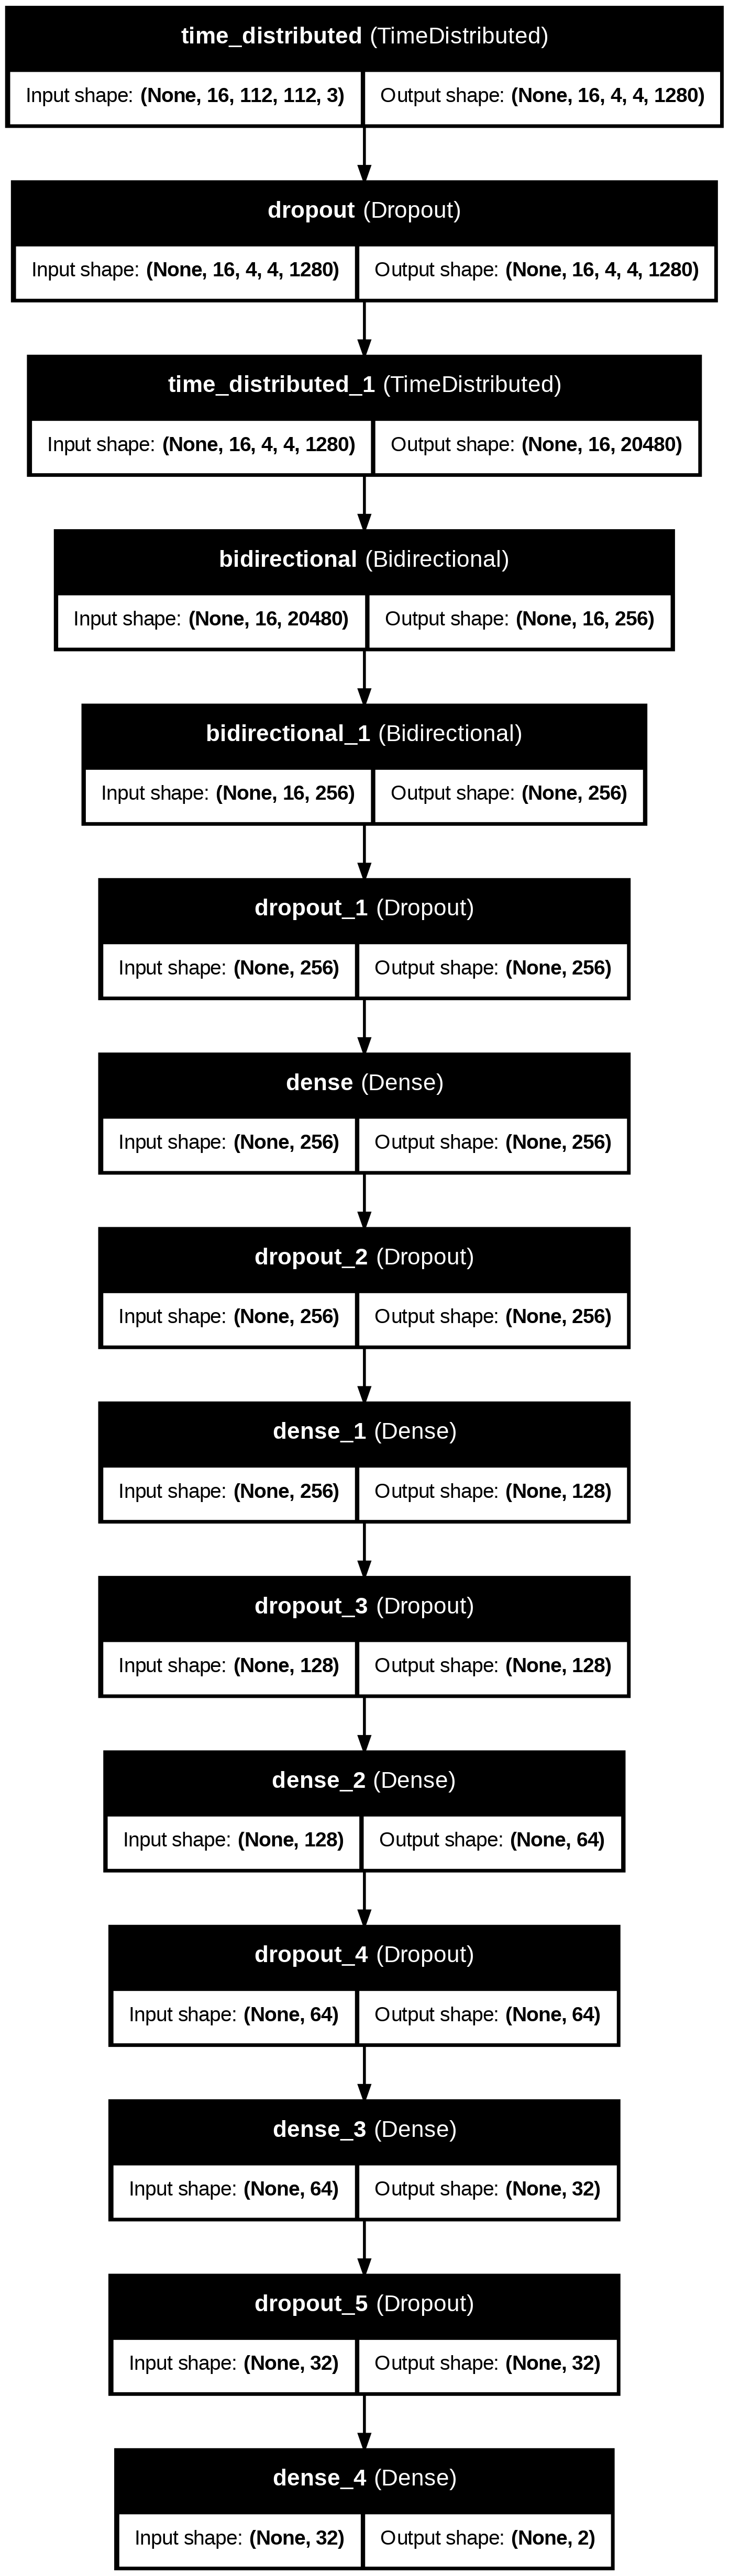

In [6]:
def create_model():
    model = Sequential()

    model.add(Input(shape=(SEQUENCE_LENGTH, FINAL_HEIGHT, FINAL_WIDTH, 3)))

    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=128)))

    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.6,
                                                patience=5,
                                                min_lr=0.00005,
                                                verbose=1)

MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                                            shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/50


I0000 00:00:1750087456.255009      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


320/320 ━━━━━━━━━━━━━━━━━━━━ 432s 561ms/step - accuracy: 0.5499 - loss: 0.6892 - val_accuracy: 0.7828 - val_loss: 0.4826 - learning_rate: 1.0000e-04
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 470ms/step - accuracy: 0.7847 - loss: 0.5117 - val_accuracy: 0.8984 - val_loss: 0.2708 - learning_rate: 1.0000e-04
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 149s 467ms/step - accuracy: 0.8879 - loss: 0.2982 - val_accuracy: 0.8828 - val_loss: 0.3038 - learning_rate: 1.0000e-04
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 468ms/step - accuracy: 0.9198 - loss: 0.2347 - val_accuracy: 0.8984 - val_loss: 0.2894 - learning_rate: 1.0000e-04
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 151s 472ms/step - accuracy: 0.9541 - loss: 0.1522 - val_accuracy: 0.9203 - val_loss: 0.2543 - learning_rate: 1.0000e-04
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 468ms/step - accuracy: 0.9799 - loss: 0.0756 - val_accuracy: 0.9141 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 151s 471ms/

In [8]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.9337 - loss: 0.4125


In [9]:
# MoBiLSTM_model.save('MoBiLSTM_model.keras')

# Load Model
# model = keras.models.load_model('MoBiLSTM_model.keras')

In [10]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

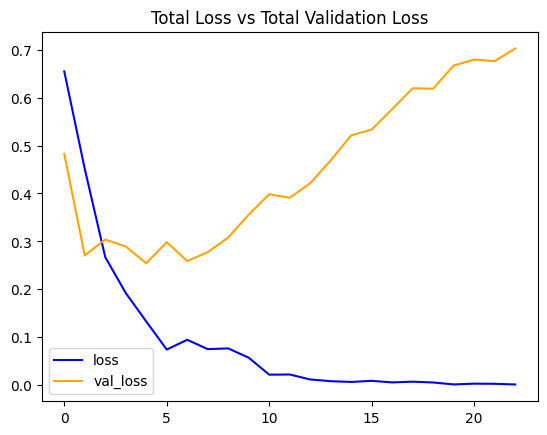

In [11]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

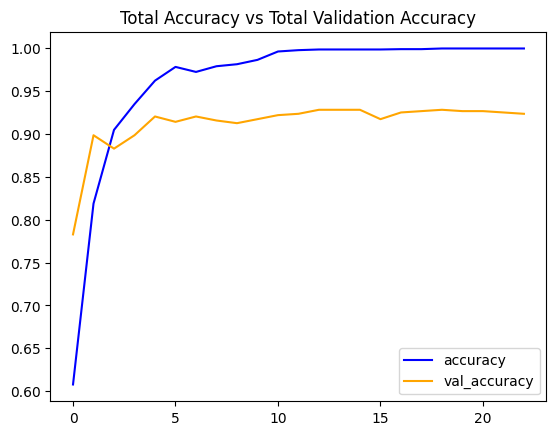

In [12]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [13]:
labels_predict = MoBiLSTM_model.predict(features_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step


In [14]:
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [15]:
labels_test_normal.shape , labels_predict.shape

((800,), (800,))

In [16]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.93375


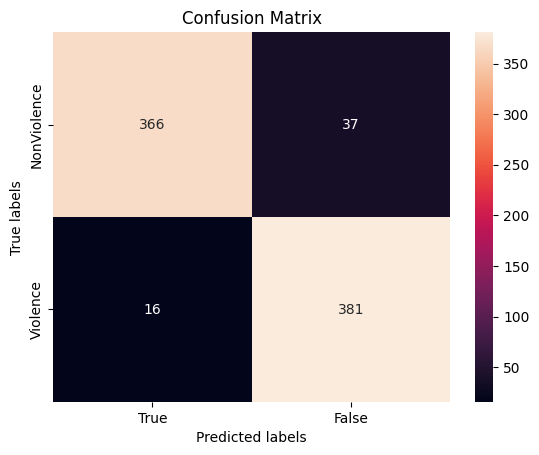

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [18]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       403
           1       0.91      0.96      0.93       397

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



In [19]:
# # **1. Frame-by-Frame Prediction with Video Display**

# def predict_single_video_with_frames(video_path, model, sequence_length=16):
#     """
#     Predict violence for a single video and return frame-by-frame analysis
#     """
#     # Extract frames from video
#     video_frames = get_video_frames(video_path)
#     if video_frames is None:
#         return None, None, None

#     # Preprocess for prediction
#     processed_frames = preprocess_test_frames(video_frames)
#     processed_frames = np.expand_dims(processed_frames, axis=0)  # Add batch dimension

#     # Get prediction
#     prediction = model.predict(processed_frames, verbose=0)
#     predicted_class = np.argmax(prediction[0])
#     confidence = np.max(prediction[0])

#     # Get original frames for display (resize for visualization)
#     display_frames = []
#     for frame in video_frames:
#         # Convert back to uint8 for display
#         if frame.dtype == np.float32:
#             display_frame = (frame * 255).astype(np.uint8)
#         else:
#             display_frame = frame
#         # Resize for better display
#         display_frame = cv2.resize(display_frame, (224, 224))
#         display_frames.append(display_frame)

#     return display_frames, predicted_class, confidence

# def display_video_frames_with_prediction(frames, predicted_class, confidence, title="Video Analysis"):
#     """
#     Display video frames in a grid with prediction results
#     """
#     class_names = ["NonViolence", "Violence"]

#     # Create figure
#     fig, axes = plt.subplots(3, 6, figsize=(20, 12))
#     fig.suptitle(f'{title}\nPrediction: {class_names[predicted_class]} (Confidence: {confidence:.3f})',
#                  fontsize=16, fontweight='bold')

#     # Display first 18 frames (3x6 grid)
#     for i in range(18):
#         row = i // 6
#         col = i % 6

#         if i < len(frames):
#             # Convert BGR to RGB for matplotlib
#             frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
#             axes[row, col].imshow(frame_rgb)
#             axes[row, col].set_title(f'Frame {i+1}', fontsize=10)

#             # Add colored border based on prediction
#             if predicted_class == 1:  # Violence
#                 rect = patches.Rectangle((0, 0), frame_rgb.shape[1]-1, frame_rgb.shape[0]-1,
#                                        linewidth=3, edgecolor='red', facecolor='none')
#             else:  # NonViolence
#                 rect = patches.Rectangle((0, 0), frame_rgb.shape[1]-1, frame_rgb.shape[0]-1,
#                                        linewidth=3, edgecolor='green', facecolor='none')
#             axes[row, col].add_patch(rect)
#         else:
#             axes[row, col].axis('off')

#         axes[row, col].axis('off')

#     plt.tight_layout()
#     plt.show()

# def Play_Video(filepath):
#     html = ''
#     video = open(filepath,'rb').read()
#     src = 'data:video/mp4;base64,' + b64encode(video).decode()
#     html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
#     return HTML(html)


# # **2. Test on Random Videos from Test Set** - Modified version with video playback

# def test_random_videos_from_testset(model, features_test, labels_test, video_files_paths, test_indices, n_videos=4):
#     """
#     Test model on random videos from test set and display results
#     """
#     class_names = ["NonViolence", "Violence"]

#     # Get random indices from test set
#     random_test_indices = random.sample(list(range(len(features_test))), min(n_videos, len(features_test)))

#     for i, test_idx in enumerate(random_test_indices):
#         print(f"\n{'='*60}")
#         print(f"VIDEO {i+1}/{len(random_test_indices)}")
#         print(f"{'='*60}")

#         # Get video info
#         original_idx = test_indices[test_idx]
#         video_path = video_files_paths[original_idx]
#         true_label = np.argmax(labels_test[test_idx])

#         print(f"Video Path: {video_path}")
#         print(f"True Label: {class_names[true_label]}")

#         # Play the original video
#         print("\nOriginal Video:")
#         display(Play_Video(video_path))

#         # Make prediction
#         test_sample = np.expand_dims(features_test[test_idx], axis=0)
#         prediction = model.predict(test_sample, verbose=0)
#         predicted_class = np.argmax(prediction[0])
#         confidence = np.max(prediction[0])

#         print(f"\nPredicted Label: {class_names[predicted_class]}")
#         print(f"Confidence: {confidence:.4f}")
#         print(f"Correct: {'✓' if predicted_class == true_label else '✗'}")

#         # Display video frames with prediction
#         frames, _, _ = predict_single_video_with_frames(video_path, model)
#         if frames is not None:
#             title = f"Video {i+1}: {os.path.basename(video_path)}"
#             display_video_frames_with_prediction(frames, predicted_class, confidence, title)

In [20]:
# print("\n1️⃣ TESTING RANDOM VIDEOS FROM TEST SET")
# test_random_videos_from_testset(MoBiLSTM_model, features_test, labels_test,
#                                video_files_paths, test_indices, n_videos=2)